*** Work in Progress ***

Pubmed Query Builder: https://pubmed.ncbi.nlm.nih.gov/advanced/

### Notes
* Dates stored in __repr__ format in JSON
* 000 = Code for unobtainable PMUID

### MeSH Terms
* Biomedical Engineering 
* Biomedical Technology
* Equipment Safety
* Equipment Design
* Prostheses and Implants

### Querys
(("Equipment and Supplies"[MeSH Terms] OR "Equipment Design"[MeSH Terms] OR "Equipment Safety"[MeSH Terms] OR "Biomedical Technology"[MeSH Terms] OR "Biomedical Engineering"[MeSH Terms]) AND 1850/01/01:1997/12/31[Date - Publication]) AND (English[Language])

(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) AND (("1850"[Date - Publication] : "2003"[Date - Publication]))

In [3]:
import pandas as pd
import json
import datetime
from collections import Counter  
from matplotlib import pyplot as plt
from pymed import PubMed
import re
import csv
from neo4j import GraphDatabase
from fuzzywuzzy import process,fuzz

In [ ]:
# TODO
# Implement date cutoff in query function

# Retrieve Data

### Functions

In [14]:
# Uses Pymed to get results for the desired query
def search(query_string, pubmed_module, max_results=2000):
    results = pubmed_module.query(query_string, max_results=max_results)
    return results

In [15]:
# Gets relevant data from Pymed iterable and creates a dictionary
def pubmed_todict(pubmed_iterable):
    new_dict = {"Result Number": [], "Pubmed ID": [], "Title": [], "Abstract":[], "Journal": [], "Authors": [], "Date": []}
    
    # Assemble dictionary
    for i, article in enumerate(pubmed_iterable):
        new_dict["Result Number"].append(i)
        if "\n" in article.pubmed_id:  # Deals with parsing issue for article PMUID
            new_dict["Pubmed ID"].append("000")
        else:
            new_dict["Pubmed ID"].append(article.pubmed_id)   
        new_dict["Title"].append(article.title)
        new_dict["Abstract"].append(article.abstract)
        try:  # Deals with books and book reviews (rather than articles) in the database
            new_dict["Journal"].append(article.journal)
        except AttributeError:
            new_dict["Journal"].append("Book") 
        new_dict["Authors"].append(article.authors)
        if type(article.publication_date) == datetime.date:  # Standardizes data. Pymed returns some years as int
            new_dict["Date"].append(article.publication_date) 
        else:
            new_dict["Date"].append(datetime.datetime.strptime(str(article.publication_date), "%Y"))
        
    # Cleans author data
    clean_author_list_by_paper = []
    for paper_author_list in new_dict["Authors"]:
        if paper_author_list == []:
            clean_author_list_by_paper.append([{"name": None, "affiliation": None}])
        else:
            author_list_by_paper = []
            for author in paper_author_list:
                if author["lastname"] != None or author["initials"] != None:
                    try:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                "affiliation": author["affiliation"]}
                    except KeyError:
                        author_dict = {"name": "{} {}".format(author["lastname"], author["initials"]),
                                    "affiliation": None}
                    author_list_by_paper.append(author_dict)
            clean_author_list_by_paper.append(author_list_by_paper)
    
    new_dict["Authors"] = clean_author_list_by_paper
    
    return new_dict

In [16]:
# Avoids serialization error with datetime in JSON dump
# See https://stackoverflow.com/questions/54557568/typeerror-object-of-type-date-is-not-json-serializable
def datetime_converter(object):
    if isinstance(object, datetime.date):
        return object.__repr__()

In [17]:
def search_and_dump(query_string, max_results, file_name):
    pubmed = PubMed(tool="Medical Device Author Network Analysis", email="bowrey@umd.edu")
    results = search(query_string=query_string, pubmed_module=pubmed, max_results=max_results)
    new_dict = pubmed_todict(pubmed_iterable=results)
    with open("JSON Data\{}".format(file_name), "w") as f:
        # Default argument takes function that is called when JSON ecounters object it can't convert
        json.dump(new_dict, f, indent=4, default=datetime_converter)
        print("Search Completed. File dumped to JSON")

### Queries

In [ ]:
# Searches for all items with "medical device(s)" in the title or abstract
search_and_dump(query_string='''(((medical device[Title/Abstract]) OR (medical devices[Title/Abstract])) AND (english[Language])) 
                                AND (("1850"[Date - Publication] : "2004"[Date - Publication]))''',
               max_results=3000, file_name="device_pubmed_data.json")

In [19]:
search_and_dump(query_string='''("Biomedical Technology"[Mesh] OR "Biomedical Engineering"[Mesh]) 
                                AND (1900:2004[pdat]) AND (english[Language])''',
               max_results=10000, file_name="biomed_pubmed_data.json")

Search Completed. File dumped to JSON


# Publication Analysis

Some articles are listed with abnormal years (e.g. years outside of the range that was input to the query). This is a problem that exists even in the PubMed browser version. These errors are not randomly distributed. They overwhelmingly happen in the final year of the search range. My current solution is to extend the search range beyond what I want (up to the year 2000), then discarding all values outside of that range. This should pick up most of the incorrectly labeled data.

In [5]:
def create_df(file_path, cutoff_year=2000):
    with open(file_path, "r") as f:
        full_dict = json.load(f)
    
    slim_dict = {key:value for (key, value) in full_dict.items() if key in ["Pubmed ID", "Title", "Journal", "Date"]}
    df = pd.DataFrame.from_dict(slim_dict)
    # df = df[df["Pubmed ID"] != "000"]  # Removes data with parsing error
    df["Date"] = df["Date"].apply(lambda x : eval(x).year)  # Converts date from __repr__ format
    
    # Cleaning years
    for index in df.loc[df["Date"] > cutoff_year].index:
        df.drop([index], inplace=True)
    
    return df

In [6]:
device_df = create_df("device_pubmed_data.json", 2000)
device_df.head(10)

,Pubmed ID,Title,Journal,Date
240,25144087,Modern Methods of Clinical Investigation: Medi...,Book,1990
241,25144034,Food and Drug Administration Advisory Committees,Book,1992
242,25121284,The Changing Economics of Medical Technology,Book,1991
243,25101448,"Safe, Comfortable, Attractive, and Easy to Use...",Book,1996
244,25077267,Rational Therapeutics for Infants and Children...,Book,2000
246,25032312,"New Medical Devices: Invention, Development, a...",Book,1988
248,21413338,Medical Microbiology,Book,1996
973,11132023,Medical technology assessment: the use of the ...,The International journal of artificial organs,2000
974,11110297,Prion disease and medical devices.,ASAIO journal (American Society for Artificial...,2000
975,11110285,Medical device associated infections.,ASAIO journal (American Society for Artificial...,2000


In [20]:
biomed_df = create_df("./JSON Data/biomed_pubmed_data.json", 2000)
biomed_df.head(10)

,Pubmed ID,Title,Journal,Date
2043,11132200,Importance of temperature and humidity in the ...,Annals of biomedical engineering,2000
2044,11132199,Biphasic material properties of lytic bone met...,Annals of biomedical engineering,2000
2045,11132198,Computer- and robot-assisted total knee replac...,Annals of biomedical engineering,2000
2046,11132197,Stimulated secretion of pituitary hormones in ...,Annals of biomedical engineering,2000
2047,11132196,Respiratory related evoked responses to gradua...,Annals of biomedical engineering,2000
2048,11132195,"Fast, robust identification of nonlinear physi...",Annals of biomedical engineering,2000
2049,11132194,Quantifying coevolution of nonstationary biome...,Annals of biomedical engineering,2000
2050,11132193,Role of preconditioning and recovery time in r...,Annals of biomedical engineering,2000
2051,11132192,Model-based analysis of optically mapped epica...,Annals of biomedical engineering,2000
2052,11132191,A three-dimensional finite element model of ra...,Annals of biomedical engineering,2000


### Publications by Year

<BarContainer object of 41 artists>

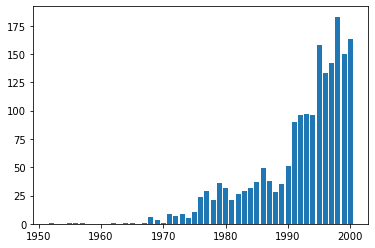

In [9]:
device_date_group = device_df.groupby(["Date"])
device_pub_year_table = device_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))
plt.bar(device_pub_year_table.index, [device_pub_year_table.get(x) for x in device_pub_year_table.index])

<BarContainer object of 51 artists>

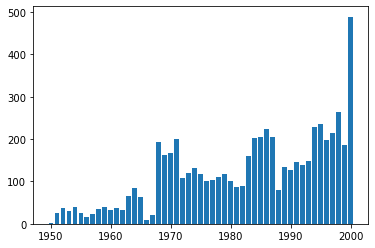

In [22]:
biomed_date_group = biomed_df.groupby(["Date"])
biomed_pub_year_table = biomed_date_group["Journal"].apply(lambda y: y.agg(lambda x : x.value_counts().sum()))
plt.bar(biomed_pub_year_table.index, [biomed_pub_year_table.get(x) for x in biomed_pub_year_table.index])

### For Export to Voyant Tools

In [ ]:
def voyant_export(year_group, dataset_name, start_year, end_year=2000):
    year_title_list = year_group["Title"].unique()
    
    for year in range(start_year, end_year + 1):
        temp_list = []
        try:
            for title in year_title_list[year]:
                title = title.replace("--", " ")
                title = title + "\n"
                temp_list.append(title)
            
            with open("Title Data Files/{a}/{b}_{a}.txt".format(b=year, a=dataset_name), "w") as f:
                f.writelines(temp_list)
       
        except KeyError:  # If there were no publication in a year in the range
            pass
    
    print("Data Exported")

Medical Device Publication Word Frequency: https://voyant-tools.org/?corpus=fa33b04ff82a6bb8eb2bb7c2b5c9837a&panels=corpusterms,termsberry,trends,summary,contexts

In [ ]:
voyant_export(year_group = device_date_group, dataset_name="med_dev", start_year=1952, end_year=2000)

# Network Analysis

In [ ]:
# Graph clustering and partitioning analysis
# David Loshin

In [4]:
# Create author info json file
def get_author_info(pubmed_data, write_file):
    identifier_list = {}
    id_count = 1
    
    # Create data structure for author
    for i, paper in enumerate(pubmed_data["Authors"]):
        for author in paper:
            if author["name"] != None:
                
                # If author is already in the dictionary
                """There one instance were an author spells his name both 'Dimets' and 'DiMets'"""
                if author["name"] in [item for item in identifier_list.keys()]:

                    # Update Values
                    identifier_list[author["name"]]["weight"] += 1
                    identifier_list[author["name"]]["years active"].append(pubmed_data["Date"][i])      

                # If the author is not already in the dictionary
                else:
                    identifier_list[author["name"]]  = {"id": id_count, 
                                                        "years active":[pubmed_data["Date"][i]], 
                                                        "affiliation":[], "weight": 1, "edges":[]}

                # Get year/affiliation data for GIS
                if author["affiliation"] != None:
                    aff = author["affiliation"]
                    aff = re.sub(r"[^@ \t\r\n]+@[^@ \t\r\n]+\.[^@ \t\r\n]+", "", aff)  # Remove emails. Some authors only list email.
                    aff = re.sub(r"(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()!@:%_\+.~#?&\/\/=]*)", "", aff)  # Remove websites
                    aff = aff.strip(" ")
                    if aff != "":  # Skips authors who only put an email as thier insitution
                        identifier_list[author["name"]]["affiliation"].append((aff, pubmed_data["Date"][i]))

                # Append other authors to edges list
                temp_list = [(o_author["name"], pubmed_data["Date"][i]) for o_author in paper]  # Co-author name and year of collaboration
                for item in temp_list:
                    if item[0] != author["name"]:
                        identifier_list[author["name"]]["edges"].append(item) 

                id_count +=1
            
    with open(write_file, "w") as f:
        json.dump(identifier_list, f, indent=4)

In [7]:
# Clean author insitituitonal affiliations useing fuzzy matching
def match_affiliation(author_data, min_ratio):
    full_list = [] 
    for author in author_data: # Extract all listed institutions
        for item in author_data[author]["affiliation"]:
            full_list.append(item[0])

    full_list = (set(full_list)) # Get unique items 
    reducing_list = full_list.copy()
    already_categorized = []
    similarity_groups = []

    for insitituiton in full_list:
        if insitituiton not in already_categorized:
            group = [insitituiton]
            already_categorized.append(insitituiton)
            ratios = process.extract(insitituiton, reducing_list, scorer=fuzz.token_set_ratio)
            for inst_ratio in ratios:
                if inst_ratio[0] != insitituiton and inst_ratio[1] > min_ratio:
                    group.append(inst_ratio[0])
                    already_categorized.append(inst_ratio[0])
                    reducing_list.remove(inst_ratio[0])
            similarity_groups.append(group)
    
    # Save groups to JSON
    group_dict_by_id = {i:keys for i,keys in enumerate(similarity_groups)}
    with open("device_institution_match.json", "w") as f:
        json.dump(group_dict_by_id, f, indent=4)
    print("Groups Saved")


In [6]:
# Create author data file
with open("device_pubmed_data.json", "r") as f:
    pubmed_data = json.load(f)
get_author_info(pubmed_data=pubmed_data, write_file="device_author_data.json")

In [8]:
# Extract and clean affiliations
with open("device_author_data.json", "r") as f:
    data = json.load(f)

match_affiliation(data, 90)

### Fuzzy Matching Error Log

In [33]:
fuzz.token_set_ratio(
    'Department of Anesthesiology, University of Washington School of Medicine and the Virginia Mason Medical Center, Seattle 98111-0900, USA.',
     'University of Virginia, USA.')

100

In [3]:
fuzz.token_set_ratio(
    "Center for Devices and Radiological Health, Food and Drug Administration, Rockville, MD 20857.",
    "Center for Devices and Radiological Health Food and Drug Administration.")

100

## Neo4J

In [11]:
driver = GraphDatabase.driver("neo4j://localhost:7687", auth=("neo4j", "devices"))

In [12]:
def create_author_node(tx, author_name, author_data):
        tx.run("MERGE (a: author {id: $id, name: $name, years_active: $years_active})", 
        id=author_data[author_name]["id"], name=author_name, 
        # Some authors have multiple papers published in the same year. Ex: Munzner RF
        years_active=list(set([eval(date).year for date in author_data[author_name]["years active"]])))

In [13]:
def add_relationships(tx, author_name, author_data):
    for coauthor in author_data[author_name]["edges"]:
        tx.run("""MATCH (a: author {id: $a_id, name: $a_name})
        MATCH (b: author {id: $b_id, name: $b_name})
        MERGE (a)-[c:COAUTHOR {date: $date}]->(b)""",
        a_id=author_data[author_name]["id"],
        a_name=author_name,
        b_id=author_data[coauthor[0]]["id"],
        b_name=coauthor[0],
        date=eval(coauthor[1]).isoformat())


In [14]:
def create_institutions_node(tx, group_id, institution_data):
    tx.run("MERGE (i: institution {id: $id, first_name:$first_name, all_names: $all_names})", 
    id=group_id, first_name=institution_data[group_id][0], 
    all_names=[name+"|" for name in institution_data[group_id]])  # | To help make separation between names more clear in Neo4j

In [15]:
def add_institution_relationships(tx, author_name, author_data, institution_data, group_dict_by_name): 
    # Make list of dates author was affiliated with location
    dates_dict = {}
    for institution in author_data[author_name]["affiliation"]:
        try:
            dates_dict[group_dict_by_name[institution[0]]].append(institution[1])
        except:
            dates_dict[group_dict_by_name[institution[0]]] = [institution[1]]

    # Execute CYPHER
    for item in dates_dict.keys():
        tx.run("""MATCH (a: author {id: $a_id, name: $a_name})
        MATCH (b: institution {id: $i_id})
        MERGE (a)<-[c:AFFILIATED {dates: $dates}]-(b)""",
        a_id=author_data[author_name]["id"],
        a_name=author_name,
        i_id=item,
        dates=[eval(date).isoformat() for date in dates_dict[item]])
        

In [16]:
with open("device_author_data.json", "r") as f:
        author_data = json.load(f)

with open("device_institution_match.json", "r") as f:
    institution_data = json.load(f)

# with driver.session() as session:
#     for author_name in author_data.keys():
#         session.write_transaction(create_author_node, author_name, author_data)

# with driver.session() as session:
#     for author_name in author_data.keys():
#         session.write_transaction(add_relationships, author_name, author_data)

with driver.session() as session:
    for group_id in institution_data.keys():
        session.write_transaction(create_institutions_node, group_id, institution_data)

with driver.session() as session:
    # Create reference dict
    group_dict_by_name = {} 
    for k,v in institution_data.items():
        for name in v:
            group_dict_by_name[name] = k
    
    # Execute CYPHER
    for author_name in author_data.keys():
        session.write_transaction(add_institution_relationships, 
        author_name, author_data, institution_data, group_dict_by_name)

# Location Analysis

In [ ]:
# Build insitutions dataframe
with open("device_author_data.json", "r") as f:
    auth_list = json.load(f)

location_dict = {"ID": [], "Location": [], "Year": []}

i = 1
for author in auth_list.values():
    if author["affiliation"] != []:
        inst = author["affiliation"]
        for item in inst:
            location_dict["ID"].append(i)
            location_dict["Location"].append(item[0])
            location_dict["Year"].append(eval(item[1]))
            i +=1

loc_df = pd.DataFrame.from_dict(location_dict)

In [ ]:
loc_df.to_csv(r"./GIS/institution_years.csv", columns=["Year"], index_label="ID")

In [ ]:
loc_df[["ID", "Year"]]

In [ ]:
# Export unique location List
un_loc_df = loc_df.drop_duplicates("Location", ignore_index=True)
#loc_df.to_csv("Medical-Device-Project/GIS/institution_locations.csv")

In [ ]:
un_loc_df

In [ ]:
loc_df